In [1]:
import pandas as pd
import time
import numpy as np
from sklearn.cross_validation import train_test_split
# import lightgbm as lgb
from pandas_summary import DataFrameSummary
pd.options.display.max_columns = 100
pd.options.display.max_rows = 50
from pathlib import Path
from fastai.structured import *

C:\Users\NokChan\Anaconda3\envs\fastai\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
import torch

## Pre-Processing

In [260]:
def prepare_data(sample = False):
    if sample == False: nrows = None
    else: nrows = 100000
    
    
    path = Path('.')

    dtypes = {
            'ip'            : 'uint32',
            'app'           : 'uint16',
            'device'        : 'uint16',
            'os'            : 'uint16',
            'channel'       : 'uint16',
            'is_attributed' : 'uint8',
            'click_id'      : 'uint32'
            }

    print('load train...')
    train_df = pd.read_csv("train.csv.zip", nrows=nrows, dtype=dtypes, usecols=['ip','app','device','os', 'channel', 'click_time', 'is_attributed'])
    print('load test...')
    test_df = pd.read_csv("test.csv.zip", nrows=nrows, dtype=dtypes, usecols=['ip','app','device','os', 'channel', 'click_time', 'click_id'])
    
    return train_df, test_df

In [261]:
sample = False

In [262]:
train_df, test_df = prepare_data(sample = sample)

load train...
load test...


In [263]:
train_df.shape, test_df.shape

((184903890, 7), (18790469, 7))

In [264]:
train_df.shape

(184903890, 7)

In [265]:
train_df.click_time = pd.to_datetime(train_df.click_time)
test_df.click_time = pd.to_datetime(test_df.click_time)

In [266]:
def add_datepart(df, fldname, drop=True):

    fld = df[fldname]
    if not np.issubdtype(fld.dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    for n in ('Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear','Hour','Minute','Second',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start'):
        df[targ_pre+n] = getattr(fld.dt,n.lower())
    df[targ_pre+'Elapsed'] = fld.astype(np.int64) // 10**9
    if drop: df.drop(fldname, axis=1, inplace=True)

In [267]:
# tables = [train_df, test_df]
# from IPython.display import HTML
# for t in tables:
#     df = DataFrameSummary(t)
#     display(t.head())
#     display(df.summary())

In [268]:
# train_df.click_time.describe()

In [269]:
# test_df.click_time.describe()

In [270]:
import gc
import re

n_train = len(train_df)
train_df=train_df.append(test_df)

del test_df
gc.collect()

print('data prep...')
add_datepart(train_df,'click_time')


gc.collect()

MemoryError: 

In [ ]:
# del test_df
gc.collect()

In [ ]:
# DataFrameSummary(train_df).summary()

Looks like the data is pretty good, no missing data issue or it may have be removed already.

In [ ]:
train_df.memory_usage().sum()/1024/1024

In [ ]:
# DataFrameSummary(train_df).summary()

In [ ]:
# # of clicks for each ip-day-hour combination
print('group by...')
gp = train_df[['ip','click_timeDay','click_timeHour','click_timeMinute','channel']].groupby(by=['ip','click_timeDay','click_timeHour','click_timeMinute'])[['channel']].count().reset_index().rename(index=str, columns={'channel': 'qty'})
print('merge...')
train_df = train_df.merge(gp, on=['ip','click_timeDay','click_timeHour','click_timeMinute'], how='left')
del gp
gc.collect()

In [ ]:
# # of clicks for each ip-app combination
print('group by...')
gp = train_df[['ip','app', 'channel']].groupby(by=['ip', 'app'])[['channel']].count().reset_index().rename(index=str, columns={'channel': 'ip_app_count'})
train_df = train_df.merge(gp, on=['ip','app'], how='left')
del gp
gc.collect()

In [ ]:
# # of clicks for each ip-app-os combination
print('group by...')
gp = train_df[['ip','app', 'os', 'channel']].groupby(by=['ip', 'app', 'os'])[['channel']].count().reset_index().rename(index=str, columns={'channel': 'ip_app_os_count'})
train_df = train_df.merge(gp, on=['ip','app', 'os'], how='left')
del gp
gc.collect()

In [ ]:
print("vars and data type: ")
train_df.info()
train_df['qty'] = train_df['qty'].astype('uint16')
train_df['ip_app_count'] = train_df['ip_app_count'].astype('uint16')
train_df['ip_app_os_count'] = train_df['ip_app_os_count'].astype('uint16')

In [ ]:
train_df.head(5)

In [ ]:
for i in ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear','Hour','Minute','Second']:
    train_df['click_time'+i] = train_df['click_time'+i].astype(np.int16)

In [ ]:
train_df.memory_usage().sum()/1024/1024

In [ ]:
n_train

In [ ]:
test_df = train_df[n_train:]
val_df = train_df[int(n_train*0.75):n_train]
train_df = train_df[:int(n_train*0.75)]

In [ ]:
def over_sample(df):
    count_class_0, count_class_1 = df.is_attributed.value_counts()

    # Divide by class
    df_class_0 = df[df['is_attributed'] == 0]
    df_class_1 = df[df['is_attributed'] == 1]
    df_class_1_over = df_class_1.sample(count_class_0, replace=True)
    df = pd.concat([df_class_0, df_class_1_over], axis=0)

    print('Random over-sampling:')
    display(df.is_attributed.value_counts().plot(kind='bar', title='Count (target)'))
    return df
    


In [ ]:
train_df = over_sample(train_df)

In [ ]:
# # Class count
# count_class_0, count_class_1 = val_df.is_attributed.value_counts()

# # Divide by class
# df_class_0 = val_df[val_df['is_attributed'] == 0]
# df_class_1 = val_df[val_df['is_attributed'] == 1]

# # df_class_0.head()

# df_class_1_over = df_class_1.sample(count_class_0, replace=True)
# val_df = pd.concat([df_class_0, df_class_1_over], axis=0)

# print('Random over-sampling:')
# val_df.is_attributed.value_counts().plot(kind='bar', title='Count (target)');

In [ ]:
print("train size: ", len(train_df))
print("valid size: ", len(val_df))
print("test size : ", len(test_df))

## Create Feature

In [ ]:
train_df.head(2)

In [ ]:
train_df.columns

In [ ]:
cat_vars = ['app', 'channel', 'device', 'ip', 'os',
       'click_timeYear', 'click_timeMonth', 'click_timeWeek', 'click_timeDay',
       'click_timeDayofweek', 'click_timeDayofyear', 'click_timeHour',
       'click_timeMinute', 'click_timeSecond', 'click_timeIs_month_end',
       'click_timeIs_month_start', 'click_timeIs_quarter_end',
       'click_timeIs_quarter_start', 'click_timeIs_year_end',
       'click_timeIs_year_start']

contin_vars = ['qty', 'ip_app_count',
       'ip_app_os_count']

n = len(train_df); n

In [ ]:
dep = 'is_attributed'
joined = train_df[cat_vars+contin_vars+[dep]].copy()

In [ ]:
test_df.columns

In [ ]:
test_df[dep] = 0
joined_test = test_df[cat_vars+contin_vars+[dep, 'click_id', 'click_timeElapsed']].copy()

In [ ]:
for v in cat_vars: joined[v] = joined[v].astype('category').cat.as_ordered()

In [ ]:
apply_cats(joined_test, joined)

In [ ]:
for v in contin_vars:
    joined[v] = joined[v].astype('float32')
    joined_test[v] = joined_test[v].astype('float32')

In [ ]:
df, y, nas, mapper = proc_df(joined, 'is_attributed', do_scale=True)
yl = np.log(y)

In [ ]:
y = y.astype(np.int64)

In [ ]:
torch.Tensor(y).type()

In [ ]:
df_test, _, nas, mapper = proc_df(joined_test, 'is_attributed', do_scale=True, skip_flds=['click_id'],
                                  mapper=mapper, na_dict=nas)

In [ ]:
df_test = df_test.set_index("click_timeElapsed")

In [ ]:
df.columns

In [ ]:
df_test.columns

## DL

In [ ]:
from fastai.column_data import *

In [ ]:
path

In [ ]:
np.arange(len(joined))[int(len(joined)*0.8) :]

In [ ]:
import pdb
# pdb.set_trace()
md = ColumnarModelData.from_data_frame(path,[-1], df, y.astype(np.int64), cat_flds=cat_vars, bs=64,
                                       test_df=None,is_reg=False, is_multi=False)

In [ ]:
cat_sz = [(c, len(joined[c].cat.categories)+1) for c in cat_vars]

In [ ]:
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]

In [ ]:
torch.cuda.is_available()

In [ ]:
a = torch.Tensor(10)

In [ ]:
torch.cuda.current_device()

In [ ]:
USE_GPU = False

In [ ]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.04, 1, [1000,500], [0.001,0.01], y_range=None)
lr = 1e-3

In [ ]:
tmp = iter(md.trn_dl)

In [ ]:
*xs,ys = next(tmp)

In [ ]:
ys.long

In [ ]:
len(xs)

In [ ]:
len(cat_vars)

In [ ]:
len(contin_vars)

In [ ]:
for i in xs:
    print(i.size())

In [ ]:
m.model.training

In [ ]:
m.model.state_dict

In [ ]:
m.lr_find()

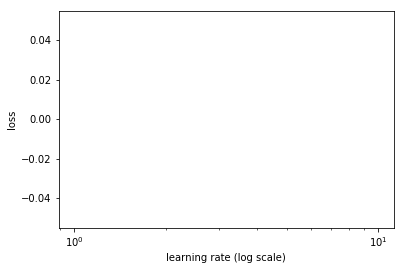

In [254]:
m.sched.plot(0,0)